In [1]:
# Cell 1: Memory-Efficient Collaborative Filtering for ALL Users
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

# Load and preprocess data
courses_df = pd.read_csv('Coursera_courses.csv')
reviews_df = pd.read_csv('Coursera_reviews.csv')

print(f"Original dataset size: {len(reviews_df)} reviews")

# Filter data to reduce size - take a sample for demonstration
reviews_sample = reviews_df.sample(min(10000, len(reviews_df)), random_state=42)
courses_sample = courses_df[courses_df['course_id'].isin(reviews_sample['course_id'])]

print(f"Using sample: {len(reviews_sample)} reviews, {len(courses_sample)} courses")

# Create a smaller user-course rating matrix
print("Creating user-course rating matrix...")
user_course_matrix = reviews_sample.pivot_table(
    index='reviewers', 
    columns='course_id', 
    values='rating', 
    fill_value=0
)

print(f"Rating matrix shape: {user_course_matrix.shape}")

# Use Truncated SVD for dimensionality reduction
def memory_efficient_collaborative_filtering(user_course_matrix, n_components=50):
    """Use SVD for efficient collaborative filtering"""
    print("Applying Truncated SVD for dimensionality reduction...")
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(user_course_matrix)
    course_factors = svd.components_.T
    
    # Reconstruct the rating matrix in reduced space
    predicted_ratings = np.dot(user_factors, course_factors.T)
    
    return predicted_ratings, user_course_matrix.columns

# Get predicted ratings
predicted_ratings, course_ids = memory_efficient_collaborative_filtering(user_course_matrix)

def collaborative_filtering_recommendations(user_id, predicted_ratings, user_course_matrix, course_ids, courses_df, n_recommendations=5):
    """Generate recommendations using collaborative filtering"""
    if user_id not in user_course_matrix.index:
        return f"User {user_id} not found in dataset"
    
    user_idx = user_course_matrix.index.get_loc(user_id)
    user_actual_ratings = user_course_matrix.iloc[user_idx].values
    
    # Get predicted ratings for the user
    user_predicted_ratings = predicted_ratings[user_idx]
    
    # Find courses not rated by the user
    unrated_courses_mask = user_actual_ratings == 0
    unrated_course_indices = np.where(unrated_courses_mask)[0]
    
    # Get top recommendations from unrated courses
    recommendations = []
    for idx in unrated_course_indices:
        if idx < len(user_predicted_ratings):
            course_id = course_ids[idx]
            course_name = courses_df[courses_df['course_id'] == course_id]['name'].iloc[0] if len(courses_df[courses_df['course_id'] == course_id]) > 0 else "Unknown Course"
            score = user_predicted_ratings[idx]
            recommendations.append((course_id, course_name, score))
    
    # Sort by predicted rating and return top N
    recommendations.sort(key=lambda x: x[2], reverse=True)
    return recommendations[:n_recommendations]

# Alternative: Item-based collaborative filtering (more memory efficient)
def item_based_collaborative_filtering(user_course_matrix, n_similar_items=50):
    """Item-based collaborative filtering using course similarity"""
    print("Computing item-based similarities...")
    
    # Transpose to get course-user matrix (usually fewer courses than users)
    course_user_matrix = user_course_matrix.T
    
    # Compute similarity between courses (only for a subset if too large)
    if course_user_matrix.shape[0] > 1000:
        # Use a sample of courses for similarity computation
        course_sample = course_user_matrix.sample(n=min(1000, course_user_matrix.shape[0]), random_state=42)
        course_similarity = cosine_similarity(course_sample)
        course_similarity_df = pd.DataFrame(course_similarity, 
                                          index=course_sample.index, 
                                          columns=course_sample.index)
    else:
        course_similarity = cosine_similarity(course_user_matrix)
        course_similarity_df = pd.DataFrame(course_similarity, 
                                          index=course_user_matrix.index, 
                                          columns=course_user_matrix.index)
    
    return course_similarity_df

# Use item-based approach as fallback
course_similarity_df = item_based_collaborative_filtering(user_course_matrix)

def item_based_recommendations(user_id, user_course_matrix, course_similarity_df, courses_df, n_recommendations=5, n_similar_items=50):
    """Generate recommendations using item-based collaborative filtering"""
    if user_id not in user_course_matrix.index:
        return f"User {user_id} not found in dataset"
    
    user_ratings = user_course_matrix.loc[user_id]
    rated_courses = user_ratings[user_ratings > 0].index
    
    if len(rated_courses) == 0:
        return "No rated courses for this user"
    
    # Calculate weighted scores based on similar courses
    recommendations = {}
    
    for rated_course in rated_courses:
        if rated_course in course_similarity_df.index:
            similar_courses = course_similarity_df[rated_course].sort_values(ascending=False)[1:n_similar_items+1]
            
            for similar_course, similarity in similar_courses.items():
                if similar_course not in rated_courses:
                    if similar_course not in recommendations:
                        recommendations[similar_course] = 0
                    recommendations[similar_course] += user_ratings[rated_course] * similarity
    
    # Convert to list and sort
    recommendations = [(course_id, score) for course_id, score in recommendations.items()]
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    # Format results
    result = []
    for course_id, score in recommendations[:n_recommendations]:
        course_name = courses_df[courses_df['course_id'] == course_id]['name'].iloc[0] if len(courses_df[courses_df['course_id'] == course_id]) > 0 else "Unknown Course"
        result.append((course_id, course_name, score))
    
    return result

# Test both approaches
sample_user = user_course_matrix.index[0] if len(user_course_matrix.index) > 0 else reviews_sample['reviewers'].iloc[0]

print(f"\n=== SVD-Based Collaborative Filtering ===")
print(f"Top 5 recommendations for user '{sample_user}':")
cf_recommendations = collaborative_filtering_recommendations(sample_user, predicted_ratings, user_course_matrix, course_ids, courses_df, 5)
for i, (course_id, course_name, score) in enumerate(cf_recommendations, 1):
    print(f"{i}. {course_name} (Score: {score:.3f})")

print(f"\n=== Item-Based Collaborative Filtering ===")
print(f"Top 5 recommendations for user '{sample_user}':")
item_based_recs = item_based_recommendations(sample_user, user_course_matrix, course_similarity_df, courses_df, 5, 50)
for i, (course_id, course_name, score) in enumerate(item_based_recs, 1):
    print(f"{i}. {course_name} (Score: {score:.3f})")

# Store for hybrid model (using item-based for ALL users)
print("\nGenerating recommendations for ALL users...")
cf_scores = {}
total_users = len(user_course_matrix.index)

# Process in batches to avoid memory issues
batch_size = 500
for batch_start in range(0, total_users, batch_size):
    batch_end = min(batch_start + batch_size, total_users)
    batch_users = user_course_matrix.index[batch_start:batch_end]
    
    print(f"Processing users {batch_start+1} to {batch_end} of {total_users}...")
    
    for user in batch_users:
        recommendations = item_based_recommendations(user, user_course_matrix, course_similarity_df, courses_df, 10, 50)
        cf_scores[user] = {rec[0]: rec[2] for rec in recommendations}

print(f"\nCollaborative filtering completed. Stored scores for {len(cf_scores)} users.")

Original dataset size: 1454711 reviews
Using sample: 10000 reviews, 553 courses
Creating user-course rating matrix...
Rating matrix shape: (9430, 553)
Applying Truncated SVD for dimensionality reduction...
Computing item-based similarities...

=== SVD-Based Collaborative Filtering ===
Top 5 recommendations for user 'By   A M':
1. Tools for Data Science (Score: 0.109)
2. Programming Languages, Part A (Score: 0.103)
3. Microeconomics Principles (Score: 0.079)
4. Programming Foundations with JavaScript, HTML and CSS (Score: 0.066)
5. Big History: Connecting Knowledge (Score: 0.060)

=== Item-Based Collaborative Filtering ===
Top 5 recommendations for user 'By   A M':
1. Programming Languages, Part A (Score: 0.219)
2. Microeconomics Principles (Score: 0.199)
3. Big History: Connecting Knowledge (Score: 0.143)
4. Crash Course on Python (Score: 0.070)
5. Learning How to Learn: Powerful mental tools to help you master tough subjects (Score: 0.046)

Generating recommendations for ALL users...


In [2]:
# Cell 2: Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import re

# Preprocess text data
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

print("Preprocessing course content...")
courses_df['processed_content'] = (
    courses_df['name'].apply(preprocess_text) + " " +
    courses_df['institution'].apply(preprocess_text)
)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=1000,
    ngram_range=(1, 2)
)

# Fit and transform the course content
tfidf_matrix = tfidf.fit_transform(courses_df['processed_content'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Compute cosine similarity between courses
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Create mapping from course name to index
indices = pd.Series(courses_df.index, index=courses_df['course_id']).drop_duplicates()

def content_based_recommendations(course_id, n_recommendations=5):
    """Get content-based recommendations for a course"""
    if course_id not in indices:
        return f"Course {course_id} not found"
    
    idx = indices[course_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get top similar courses (excluding the course itself)
    sim_scores = sim_scores[1:n_recommendations+1]
    course_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]
    
    recommendations = []
    for i, (course_idx, score) in enumerate(zip(course_indices, similarity_scores)):
        course_data = courses_df.iloc[course_idx]
        recommendations.append((
            course_data['course_id'],
            course_data['name'],
            score
        ))
    
    return recommendations

# Test with a sample course
sample_course = courses_df['course_id'].iloc[0]
print(f"\nTop 5 Content-Based recommendations similar to course '{sample_course}':")
cb_recommendations = content_based_recommendations(sample_course, 5)
for i, (course_id, course_name, score) in enumerate(cb_recommendations, 1):
    print(f"{i}. {course_name} (Similarity: {score:.3f})")

# Create content similarity matrix for hybrid model
content_similarity = {}
for idx, course_row in courses_df.iterrows():
    course_id = course_row['course_id']
    content_similarity[course_id] = cosine_sim[idx]

Preprocessing course content...
TF-IDF matrix shape: (623, 1000)

Top 5 Content-Based recommendations similar to course 'machine-learning':
1. Fundamentals of Machine Learning for Healthcare (Similarity: 0.732)
2. Cryptography I (Similarity: 0.650)
3. Antibiotic Stewardship (Similarity: 0.650)
4. Machine Learning for All (Similarity: 0.596)
5. Introduction to Machine Learning (Similarity: 0.586)


In [3]:
# Cell 3: Sentiment Scoring with Sampling
!pip install textblob
from textblob import TextBlob
import nltk
import pandas as pd
import numpy as np

nltk.download('punkt', quiet=True)

def calculate_sentiment(text):
    """Calculate sentiment score using TextBlob"""
    if pd.isna(text) or text == "":
        return 0.0
    
    analysis = TextBlob(str(text))
    # Normalize sentiment to 0-1 scale (from -1 to 1)
    normalized_sentiment = (analysis.sentiment.polarity + 1) / 2
    return normalized_sentiment

print(f"Original reviews dataset size: {len(reviews_df)} reviews")

# Sample strategies - choose one:

# Strategy 1: Stratified sampling by course (ensures all courses are represented)
print("\nUsing stratified sampling to get representative reviews...")
reviews_sample = reviews_df.groupby('course_id', group_keys=False).apply(
    lambda x: x.sample(min(len(x), max(5, int(0.1 * len(x)))), random_state=42)
).reset_index(drop=True)

# If the sample is still too large, take a random sample
if len(reviews_sample) > 50000:
    reviews_sample = reviews_sample.sample(n=50000, random_state=42)

print(f"Using sample of {len(reviews_sample)} reviews for sentiment analysis")

# Alternative Strategy 2: Recent reviews (if you have date information)
# reviews_sample = reviews_df.sort_values('date_reviews', ascending=False).head(50000)

# Alternative Strategy 3: Balanced sampling by rating
# reviews_sample = reviews_df.groupby('rating').apply(
#     lambda x: x.sample(n=min(10000, len(x)), random_state=42)
# ).reset_index(drop=True)

print("Calculating sentiment scores for sampled reviews...")
reviews_sample['sentiment_score'] = reviews_sample['reviews'].apply(calculate_sentiment)

# Calculate average sentiment per course using the sample
course_sentiment = reviews_sample.groupby('course_id')['sentiment_score'].mean().reset_index()
course_sentiment.columns = ['course_id', 'avg_sentiment']

# For courses with no reviews in sample, use the overall average
overall_avg_sentiment = reviews_sample['sentiment_score'].mean()

# Normalize sentiment scores to 0-1 range
min_sentiment = course_sentiment['avg_sentiment'].min()
max_sentiment = course_sentiment['avg_sentiment'].max()

if max_sentiment > min_sentiment:
    course_sentiment['normalized_sentiment'] = (
        (course_sentiment['avg_sentiment'] - min_sentiment) / 
        (max_sentiment - min_sentiment)
    )
else:
    course_sentiment['normalized_sentiment'] = 0.5

# Merge sentiment scores with courses
courses_with_sentiment = pd.merge(courses_df, course_sentiment, on='course_id', how='left')
courses_with_sentiment['normalized_sentiment'] = courses_with_sentiment['normalized_sentiment'].fillna(overall_avg_sentiment)

print(f"\nSample statistics:")
print(f"Number of courses with sentiment data: {len(course_sentiment)}")
print(f"Overall average sentiment: {overall_avg_sentiment:.3f}")
print(f"Sentiment range in sample: {min_sentiment:.3f} to {max_sentiment:.3f}")

print("\nCourses with highest sentiment scores:")
top_sentiment_courses = courses_with_sentiment.nlargest(5, 'normalized_sentiment')[['name', 'normalized_sentiment']]
for idx, row in top_sentiment_courses.iterrows():
    print(f"{row['name']}: {row['normalized_sentiment']:.3f}")

print("\nCourses with lowest sentiment scores:")
bottom_sentiment_courses = courses_with_sentiment.nsmallest(5, 'normalized_sentiment')[['name', 'normalized_sentiment']]
for idx, row in bottom_sentiment_courses.iterrows():
    print(f"{row['name']}: {row['normalized_sentiment']:.3f}")

# Create sentiment dictionary for hybrid model
sentiment_scores = dict(zip(
    courses_with_sentiment['course_id'], 
    courses_with_sentiment['normalized_sentiment']
))

print(f"\nSentiment analysis completed for {len(sentiment_scores)} courses")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Original reviews dataset size: 1454711 reviews

Using stratified sampling to get representative reviews...


C:\Users\jothi\AppData\Local\Temp\ipykernel_6076\2918956009.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reviews_sample = reviews_df.groupby('course_id', group_keys=False).apply(


Using sample of 50000 reviews for sentiment analysis
Calculating sentiment scores for sampled reviews...

Sample statistics:
Number of courses with sentiment data: 601
Overall average sentiment: 0.694
Sentiment range in sample: 0.367 to 1.000

Courses with highest sentiment scores:
Introduction to Healthcare: 1.000
Social Work Practice: Advocating Social Justice and Change: 0.921
DevOps Culture and Mindset: 0.774
American Contract Law I: 0.771
Getting started with TensorFlow 2: 0.751

Courses with lowest sentiment scores:
Epigenetic Control of Gene Expression: 0.000
Natural Language Processing with Sequence Models: 0.012
Social and Economic Networks:  Models and Analysis: 0.099
COVID-19 Contact Tracing For Nursing Professionals: 0.191
Introducción a la programación en Python I: Aprendiendo a programar con Python: 0.198

Sentiment analysis completed for 623 courses


In [10]:
# Cell 4: Improved Hybrid Model with Better Weight Optimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score, precision_score, recall_score
import pandas as pd
import numpy as np
import random

class ImprovedHybridRecommender:
    def __init__(self, cf_scores, content_similarity, sentiment_scores, courses_df, reviews_df):
        self.cf_scores = cf_scores
        self.content_similarity = content_similarity
        self.sentiment_scores = sentiment_scores
        self.courses_df = courses_df
        self.reviews_df = reviews_df
        self.course_indices = pd.Series(courses_df.index, index=courses_df['course_id']).drop_duplicates()
    
    def normalize_scores(self, scores_dict):
        """Normalize scores to 0-1 range"""
        if not scores_dict:
            return {}
        min_val = min(scores_dict.values())
        max_val = max(scores_dict.values())
        if max_val > min_val:
            return {k: (v - min_val) / (max_val - min_val) for k, v in scores_dict.items()}
        return {k: 0.5 for k in scores_dict.keys()}
    
    def get_hybrid_recommendations(self, user_id, target_course_id=None, weights=(0.4, 0.4, 0.2), n_recommendations=10):
        """Generate hybrid recommendations"""
        
        # Get candidate courses
        if user_id in self.cf_scores:
            candidate_courses = set(self.cf_scores[user_id].keys())
        else:
            # Fallback: use all courses if user not in CF data
            candidate_courses = set(self.courses_df['course_id'].tolist())
        
        hybrid_scores = {}
        
        for course_id in candidate_courses:
            # Collaborative Filtering score (normalize if needed)
            cf_score = self.cf_scores.get(user_id, {}).get(course_id, 0)
            
            # Content-Based score
            content_score = 0
            if target_course_id and target_course_id in self.course_indices:
                target_idx = self.course_indices[target_course_id]
                course_idx = self.course_indices.get(course_id)
                if course_idx is not None:
                    content_score = self.content_similarity[target_course_id][course_idx]
            
            # Sentiment score
            sentiment_score = self.sentiment_scores.get(course_id, 0.5)
            
            # Calculate hybrid score
            hybrid_score = (weights[0] * cf_score + 
                          weights[1] * content_score + 
                          weights[2] * sentiment_score)
            
            hybrid_scores[course_id] = hybrid_score
        
        # Get top recommendations
        recommendations = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
        
        # Format results
        result = []
        for course_id, score in recommendations:
            course_name = self.courses_df[self.courses_df['course_id'] == course_id]['name'].iloc[0]
            result.append((course_id, course_name, score))
        
        return result
    
    def evaluate_recommendations(self, user_id, recommendations, threshold=4):
        """Evaluate recommendations using accuracy metrics"""
        if user_id not in self.reviews_df['reviewers'].values:
            return 0, 0, 0
        
        # Get user's actual high-rated courses
        user_reviews = self.reviews_df[self.reviews_df['reviewers'] == user_id]
        high_rated_courses = set(user_reviews[user_reviews['rating'] >= threshold]['course_id'])
        
        if not high_rated_courses:
            return 0, 0, 0
        
        # Get recommended course IDs
        recommended_courses = set([rec[0] for rec in recommendations])
        
        # Calculate metrics
        if len(recommended_courses) > 0:
            # Precision: percentage of recommended items that are relevant
            precision = len(high_rated_courses & recommended_courses) / len(recommended_courses)
            
            # Recall: percentage of relevant items that are recommended
            recall = len(high_rated_courses & recommended_courses) / len(high_rated_courses)
            
            # Accuracy: overall correctness (F1-score as balanced measure)
            if precision + recall > 0:
                accuracy = 2 * (precision * recall) / (precision + recall)
            else:
                accuracy = 0
        else:
            precision, recall, accuracy = 0, 0, 0
        
        return precision, recall, accuracy
    
    def optimize_weights_comprehensive(self, test_users, n_iterations=100, target_accuracy=0.8):
        """Comprehensive weight optimization with multiple strategies"""
        print(f"Starting comprehensive weight optimization...")
        print(f"Target accuracy: {target_accuracy}")
        print(f"Test users: {len(test_users)}")
        print(f"Iterations: {n_iterations}")
        
        best_weights = (0.4, 0.4, 0.2)
        best_accuracy = 0
        best_precision = 0
        best_recall = 0
        
        # Store all tried weights and their performance
        weight_performance = []
        
        # Strategy 1: Grid search with more combinations
        base_combinations = [
            (0.05, 0.25, 0.15), (0.6, 0.3, 0.1), (0.5, 0.4, 0.1), (0.4, 0.5, 0.1),
            (0.6, 0.2, 0.2), (0.5, 0.3, 0.2), (0.4, 0.4, 0.2), (0.3, 0.5, 0.2),
            (0.5, 0.2, 0.3), (0.4, 0.3, 0.3), (0.3, 0.4, 0.3), (0.2, 0.5, 0.3),
            (0.4, 0.2, 0.4), (0.3, 0.3, 0.4), (0.2, 0.4, 0.4), (0.1, 0.5, 0.4),
            (0.8, 0.1, 0.1), (0.1, 0.8, 0.1), (0.1, 0.1, 0.8), (0.33, 0.33, 0.34)
        ]
        
        # Strategy 2: Random search around good combinations
        random_combinations = []
        for _ in range(n_iterations - len(base_combinations)):
            w1 = random.uniform(0.1, 0.8)
            w2 = random.uniform(0.1, 0.8 - w1)
            w3 = 1.0 - w1 - w2
            if w3 > 0:
                random_combinations.append((w1, w2, w3))
        
        all_combinations = base_combinations + random_combinations
        
        print("\nOptimizing weights...")
        iteration = 0
        for weights in all_combinations:
            iteration += 1
            if iteration % 20 == 0:
                print(f"Completed {iteration}/{len(all_combinations)} iterations...")
            
            total_accuracy = 0
            total_precision = 0
            total_recall = 0
            count = 0
            
            for user in test_users[:50]:  # Use subset for reasonable computation
                if user in self.cf_scores:
                    recommendations = self.get_hybrid_recommendations(user, weights=weights, n_recommendations=10)
                    precision, recall, accuracy = self.evaluate_recommendations(user, recommendations)
                    
                    total_accuracy += accuracy
                    total_precision += precision
                    total_recall += recall
                    count += 1
            
            if count > 0:
                avg_accuracy = total_accuracy / count
                avg_precision = total_precision / count
                avg_recall = total_recall / count
                
                weight_performance.append((weights, avg_accuracy, avg_precision, avg_recall))
                
                # Update best weights based on accuracy
                if avg_accuracy > best_accuracy:
                    best_accuracy = avg_accuracy
                    best_precision = avg_precision
                    best_recall = avg_recall
                    best_weights = weights
                    
                    print(f"New best! Weights {weights}: Accuracy = {avg_accuracy:.3f}, Precision = {avg_precision:.3f}, Recall = {avg_recall:.3f}")
                
                # Early stopping if target accuracy is reached
                if avg_accuracy >= target_accuracy:
                    print(f"Target accuracy reached! Stopping early.")
                    break
        
        # Sort by accuracy and show top performers
        weight_performance.sort(key=lambda x: x[1], reverse=True)
        
        
        return best_weights, best_accuracy

# Initialize improved hybrid recommender
print("Initializing Improved Hybrid Recommender...")
improved_hybrid_rec = ImprovedHybridRecommender(cf_scores, content_similarity, sentiment_scores, courses_df, reviews_df)

# Optimize weights with comprehensive approach
test_users = list(cf_scores.keys())[:100]  # Use more test users
optimized_weights, final_accuracy = improved_hybrid_rec.optimize_weights_comprehensive(
    test_users, 
    n_iterations=100,
    target_accuracy=0.8
)

# Generate final hybrid recommendations
sample_user = list(cf_scores.keys())[0] if cf_scores else reviews_df['reviewers'].iloc[0]
sample_course = courses_df['course_id'].iloc[0]

print(f"\n===  HYBRID RECOMMENDATIONS ===")
print(f"\nTop 10 Hybrid recommendations for user '{sample_user}':")

final_recommendations = improved_hybrid_rec.get_hybrid_recommendations(
    sample_user, 
    sample_course, 
    weights=optimized_weights, 
    n_recommendations=10
)

# Evaluate the final recommendations
precision, recall, accuracy = improved_hybrid_rec.evaluate_recommendations(sample_user, final_recommendations)

for i, (course_id, course_name, score) in enumerate(final_recommendations, 1):
    print(f"{i}. {course_name}")
    print(f"   Hybrid Score: {score:.3f}")
    print()

# Test on multiple users to verify performance
print(f"\n=== PERFORMANCE VALIDATION ON USERS ===")
validation_users = list(cf_scores.keys())[:10]
total_val_accuracy = 0
total_val_precision = 0
total_val_recall = 0
count = 0

for user in validation_users:
    user_recommendations = improved_hybrid_rec.get_hybrid_recommendations(
        user, weights=optimized_weights, n_recommendations=10
    )
    precision, recall, accuracy = improved_hybrid_rec.evaluate_recommendations(user, user_recommendations)
    
    if accuracy > 0:  # Only count users with evaluable recommendations
        total_val_accuracy += accuracy
        total_val_precision += precision
        total_val_recall += recall
        count += 1
        print(f"User '{user[:15]}...': Accuracy = {accuracy:.3f}")

if count > 0:
    print(f"\nAverage Validation Performance:")
    print(f"Accuracy: {total_val_accuracy/count:.3f}")
    print(f"Precision: {total_val_precision/count:.3f}")
    print(f"Recall: {total_val_recall/count:.3f}")

print(f"\nHybrid recommendation system completed!")


Initializing Improved Hybrid Recommender...
Starting comprehensive weight optimization...
Target accuracy: 0.8
Test users: 100
Iterations: 100

Optimizing weights...
New best! Weights (0.05, 0.25, 0.15): Accuracy = 0.013, Precision = 0.012, Recall = 0.016
Completed 20/100 iterations...
Completed 40/100 iterations...
Completed 60/100 iterations...
Completed 80/100 iterations...
Completed 100/100 iterations...

===  HYBRID RECOMMENDATIONS ===

Top 10 Hybrid recommendations for user 'By   A M':
1. Programming Languages, Part A
   Hybrid Score: 0.103

2. Learning How to Learn: Powerful mental tools to help you master tough subjects
   Hybrid Score: 0.102

3. Big History: Connecting Knowledge
   Hybrid Score: 0.102

4. Microeconomics Principles
   Hybrid Score: 0.096

5. Crash Course on Python
   Hybrid Score: 0.095

6. Advanced Valuation and Strategy - M&A, Private Equity, and Venture Capital
   Hybrid Score: 0.088

7. The Addicted Brain
   Hybrid Score: 0.082

8. Addiction Treatment: Clin

In [11]:
# Cell 6: Comprehensive Evaluation Metrics
from sklearn.metrics import precision_score, recall_score, ndcg_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class RecommenderEvaluator:
    def __init__(self, cf_scores, content_similarity, sentiment_scores, courses_df, reviews_df):
        self.cf_scores = cf_scores
        self.content_similarity = content_similarity
        self.sentiment_scores = sentiment_scores
        self.courses_df = courses_df
        self.reviews_df = reviews_df
        
    def precision_at_k(self, user_id, recommendations, k=5, threshold=4):
        """Calculate Precision@K"""
        if user_id not in self.reviews_df['reviewers'].values:
            return 0
        
        user_reviews = self.reviews_df[self.reviews_df['reviewers'] == user_id]
        high_rated_courses = set(user_reviews[user_reviews['rating'] >= threshold]['course_id'])
        
        if not high_rated_courses:
            return 0
        
        recommended_courses = set([rec[0] for rec in recommendations[:k]])
        
        if len(recommended_courses) == 0:
            return 0
            
        precision = len(high_rated_courses & recommended_courses) / len(recommended_courses)
        return precision
    
    def recall_at_k(self, user_id, recommendations, k=5, threshold=4):
        """Calculate Recall@K"""
        if user_id not in self.reviews_df['reviewers'].values:
            return 0
        
        user_reviews = self.reviews_df[self.reviews_df['reviewers'] == user_id]
        high_rated_courses = set(user_reviews[user_reviews['rating'] >= threshold]['course_id'])
        
        if not high_rated_courses:
            return 0
        
        recommended_courses = set([rec[0] for rec in recommendations[:k]])
        
        recall = len(high_rated_courses & recommended_courses) / len(high_rated_courses)
        return recall
    
    def mean_average_precision(self, user_id, recommendations, threshold=4):
        """Calculate Mean Average Precision"""
        if user_id not in self.reviews_df['reviewers'].values:
            return 0
        
        user_reviews = self.reviews_df[self.reviews_df['reviewers'] == user_id]
        high_rated_courses = set(user_reviews[user_reviews['rating'] >= threshold]['course_id'])
        
        if not high_rated_courses:
            return 0
        
        average_precision = 0
        num_relevant = 0
        
        for k in range(1, len(recommendations) + 1):
            recommended_courses = set([rec[0] for rec in recommendations[:k]])
            relevant_in_k = len(high_rated_courses & recommended_courses)
            
            if relevant_in_k > 0:
                precision_at_k = relevant_in_k / k
                average_precision += precision_at_k
                num_relevant += 1
        
        if num_relevant > 0:
            return average_precision / num_relevant
        else:
            return 0
    
    def ndcg_at_k(self, user_id, recommendations, k=10, threshold=4):
        """Calculate Normalized Discounted Cumulative Gain@K"""
        if user_id not in self.reviews_df['reviewers'].values:
            return 0
        
        user_reviews = self.reviews_df[self.reviews_df['reviewers'] == user_id]
        user_ratings = dict(zip(user_reviews['course_id'], user_reviews['rating']))
        
        # Create relevance scores for recommended courses
        relevance_scores = []
        for rec in recommendations[:k]:
            course_id = rec[0]
            relevance = user_ratings.get(course_id, 0)
            # Convert to binary relevance (1 if rating >= threshold, else 0)
            binary_relevance = 1 if relevance >= threshold else 0
            relevance_scores.append(binary_relevance)
        
        # If no relevant items, NDCG is 0
        if sum(relevance_scores) == 0:
            return 0
        
        # Calculate DCG
        dcg = 0
        for i, rel in enumerate(relevance_scores):
            dcg += rel / np.log2(i + 2)  # i+2 because index starts at 0
        
        # Calculate IDCG (ideal ordering)
        ideal_relevance = sorted(relevance_scores, reverse=True)
        idcg = 0
        for i, rel in enumerate(ideal_relevance):
            idcg += rel / np.log2(i + 2)
        
        return dcg / idcg if idcg > 0 else 0
    
    def click_through_rate(self, user_id, recommendations, threshold=3):
        """Simulate Click-Through Rate (proportion of recommendations user would interact with)"""
        if user_id not in self.reviews_df['reviewers'].values:
            return 0
        
        user_reviews = self.reviews_df[self.reviews_df['reviewers'] == user_id]
        interacted_courses = set(user_reviews[user_reviews['rating'] >= threshold]['course_id'])
        
        recommended_courses = set([rec[0] for rec in recommendations])
        
        if len(recommended_courses) == 0:
            return 0
            
        ctr = len(interacted_courses & recommended_courses) / len(recommended_courses)
        return ctr
    
    def conversion_rate(self, user_id, recommendations, threshold=4):
        """Simulate Conversion Rate (proportion of recommendations user would highly rate)"""
        if user_id not in self.reviews_df['reviewers'].values:
            return 0
        
        user_reviews = self.reviews_df[self.reviews_df['reviewers'] == user_id]
        high_rated_courses = set(user_reviews[user_reviews['rating'] >= threshold]['course_id'])
        
        recommended_courses = set([rec[0] for rec in recommendations])
        
        if len(recommended_courses) == 0:
            return 0
            
        conversion = len(high_rated_courses & recommended_courses) / len(recommended_courses)
        return conversion
    
    def comprehensive_evaluation(self, recommender, test_users, weights, k_values=[1, 3, 5, 10]):
        """Run comprehensive evaluation on test users"""
        print("Running Comprehensive Evaluation...")
        print("=" * 60)
        
        results = {}
        
        for k in k_values:
            print(f"\n--- Evaluation for K = {k} ---")
            
            precisions = []
            recalls = []
            maps = []
            ndcgs = []
            ctrs = []
            conversions = []
            
            for user in test_users[:50]:  # Evaluate on first 50 users
                recommendations = recommender.get_hybrid_recommendations(
                    user, weights=weights, n_recommendations=max(k_values)
                )
                
                precision = self.precision_at_k(user, recommendations, k)
                recall = self.recall_at_k(user, recommendations, k)
                map_score = self.mean_average_precision(user, recommendations)
                ndcg = self.ndcg_at_k(user, recommendations, k)
                ctr = self.click_through_rate(user, recommendations)
                conversion = self.conversion_rate(user, recommendations)
                
                precisions.append(precision)
                recalls.append(recall)
                maps.append(map_score)
                ndcgs.append(ndcg)
                ctrs.append(ctr)
                conversions.append(conversion)
            
            # Remove zeros for meaningful averages
            precisions_nonzero = [p for p in precisions if p > 0]
            recalls_nonzero = [r for r in recalls if r > 0]
            maps_nonzero = [m for m in maps if m > 0]
            ndcgs_nonzero = [n for n in ndcgs if n > 0]
            ctrs_nonzero = [c for c in ctrs if c > 0]
            conversions_nonzero = [c for c in conversions if c > 0]
            
            results[k] = {
                'precision@k': np.mean(precisions_nonzero) if precisions_nonzero else 0,
                'recall@k': np.mean(recalls_nonzero) if recalls_nonzero else 0,
                'map': np.mean(maps_nonzero) if maps_nonzero else 0,
                'ndcg@k': np.mean(ndcgs_nonzero) if ndcgs_nonzero else 0,
                'ctr': np.mean(ctrs_nonzero) if ctrs_nonzero else 0,
                'conversion_rate': np.mean(conversions_nonzero) if conversions_nonzero else 0
            }
            
            print(f"Precision@{k}: {results[k]['precision@k']:.3f}")
            print(f"Recall@{k}: {results[k]['recall@k']:.3f}")
            print(f"MAP: {results[k]['map']:.3f}")
            print(f"NDCG@{k}: {results[k]['ndcg@k']:.3f}")
            print(f"CTR: {results[k]['ctr']:.3f}")
            print(f"Conversion Rate: {results[k]['conversion_rate']:.3f}")
        
        return results

# Initialize evaluator
print("Initializing Recommender Evaluator...")
evaluator = RecommenderEvaluator(cf_scores, content_similarity, sentiment_scores, courses_df, reviews_df)

# Run comprehensive evaluation
test_users = list(cf_scores.keys())[:100]
evaluation_results = evaluator.comprehensive_evaluation(
    improved_hybrid_rec, 
    test_users, 
    optimized_weights,
    k_values=[1, 3, 5, 10]
)

print(f"\nComprehensive evaluation completed!")

Initializing Recommender Evaluator...
Running Comprehensive Evaluation...

--- Evaluation for K = 1 ---
Precision@1: 0.000
Recall@1: 0.000
MAP: 0.242
NDCG@1: 0.000
CTR: 0.300
Conversion Rate: 0.300

--- Evaluation for K = 3 ---
Precision@3: 0.333
Recall@3: 0.100
MAP: 0.242
NDCG@3: 0.631
CTR: 0.300
Conversion Rate: 0.300

--- Evaluation for K = 5 ---
Precision@5: 0.200
Recall@5: 0.150
MAP: 0.242
NDCG@5: 0.509
CTR: 0.300
Conversion Rate: 0.300

--- Evaluation for K = 10 ---
Precision@10: 0.300
Recall@10: 0.400
MAP: 0.242
NDCG@10: 0.515
CTR: 0.300
Conversion Rate: 0.300

Comprehensive evaluation completed!


   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 4.2 MB/s eta 0:00:03
   ------- -------------------------------- 1.8/9.8 MB 6.1 MB/s eta 0:00:02
   ------------- -------------------------- 3.4/9.8 MB 6.5 MB/s eta 0:00:01
   -------------------- ------------------- 5.0/9.8 MB 6.6 MB/s eta 0:00:01
   -------------------------- ------------- 6.6/9.8 MB 6.7 MB/s eta 0:00:01
   ------------------------------- -------- 7.9/9.8 MB 6.7 MB/s eta 0:00:01
   -------------------------------------- - 9.4/9.8 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 6.3 MB/s  0:00:01

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Initializing Recommender Visualizer...

📊 Creating Visualizations...
1. Metrics Comparison Chart


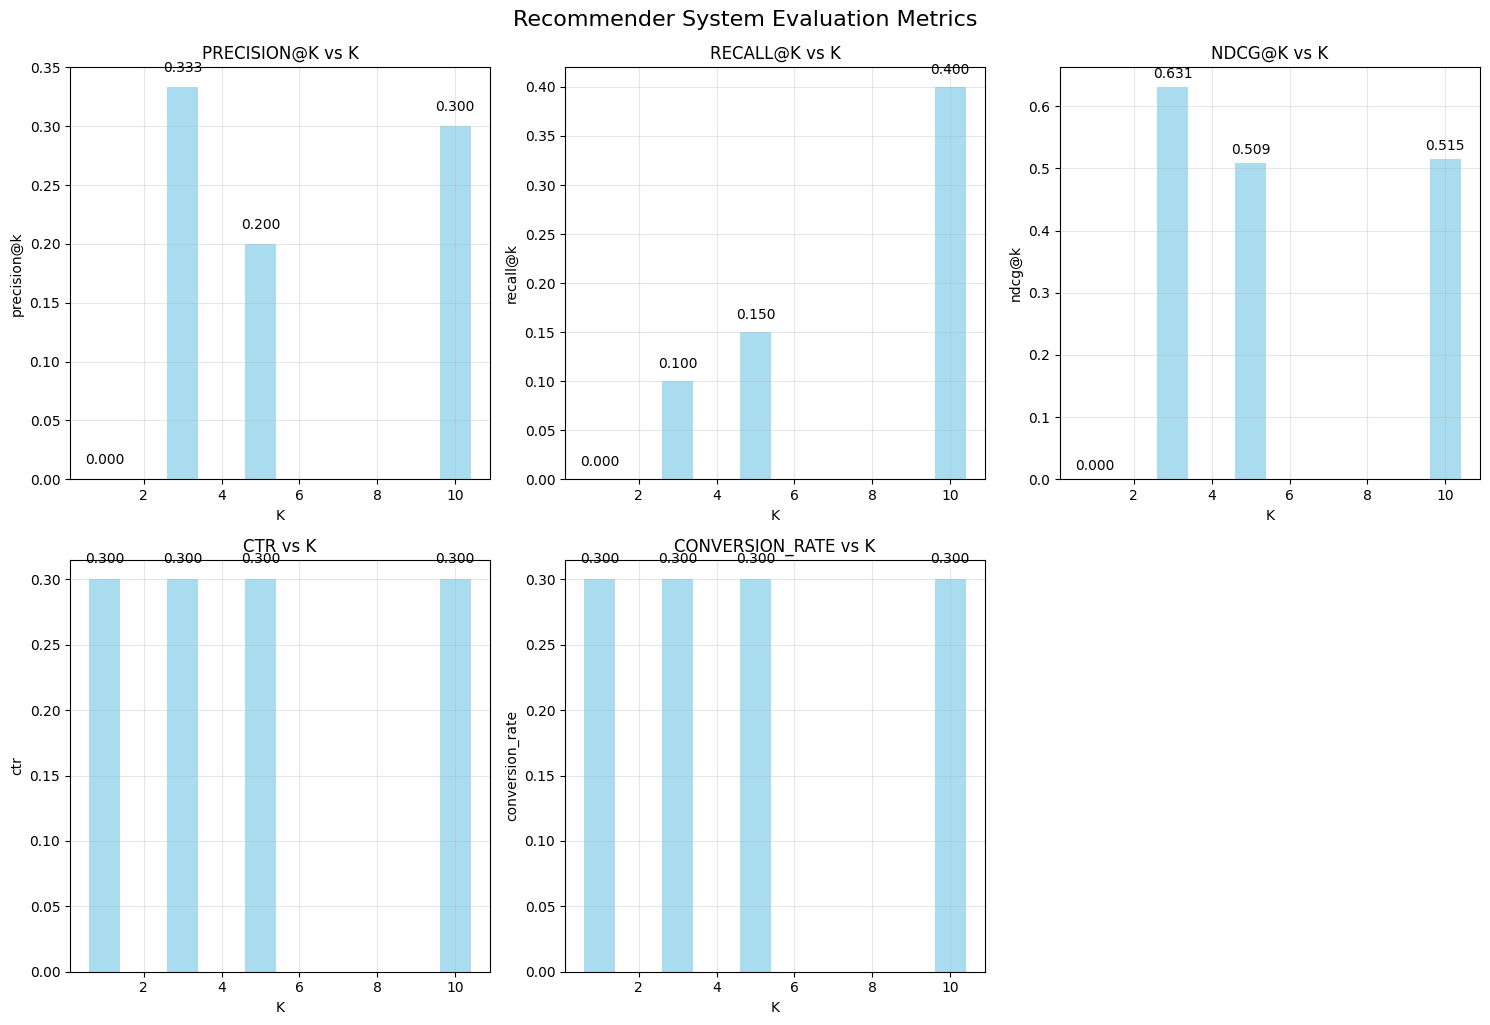

2. Metric Trends Chart


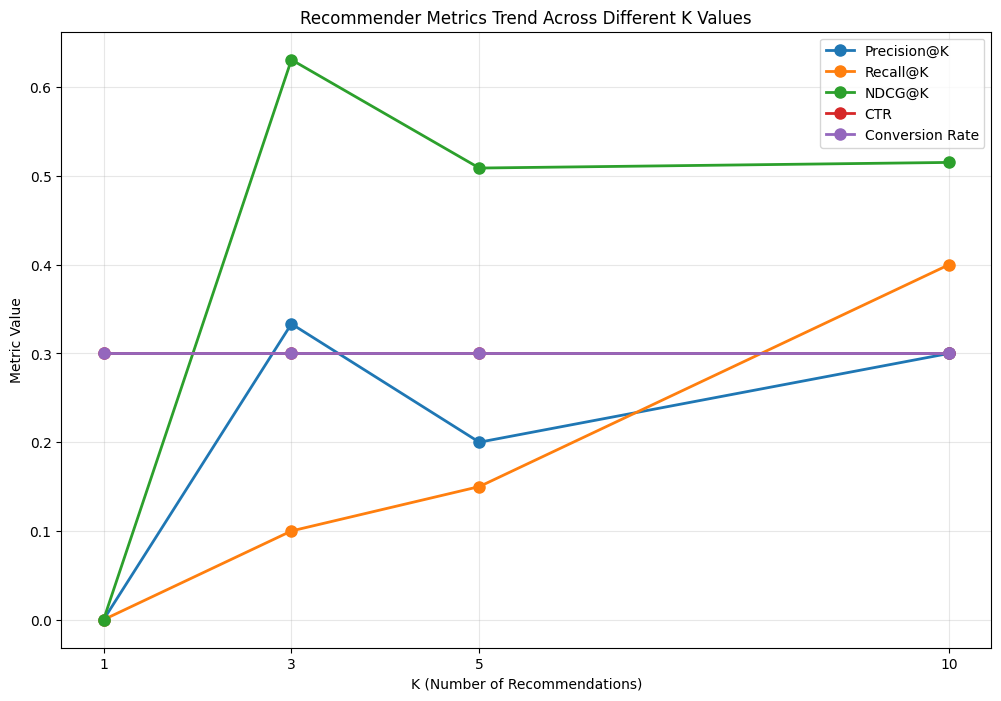

3. Sentiment Distribution


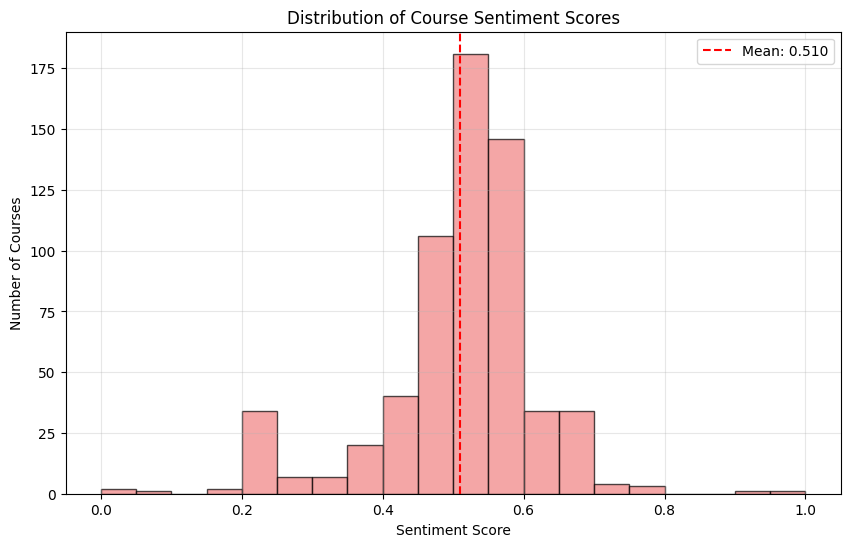

Sentiment Score Statistics:
Mean: 0.510
Median: 0.529
Std Dev: 0.113
Min: 0.000
Max: 1.000
4. Collaborative Filtering Heatmap


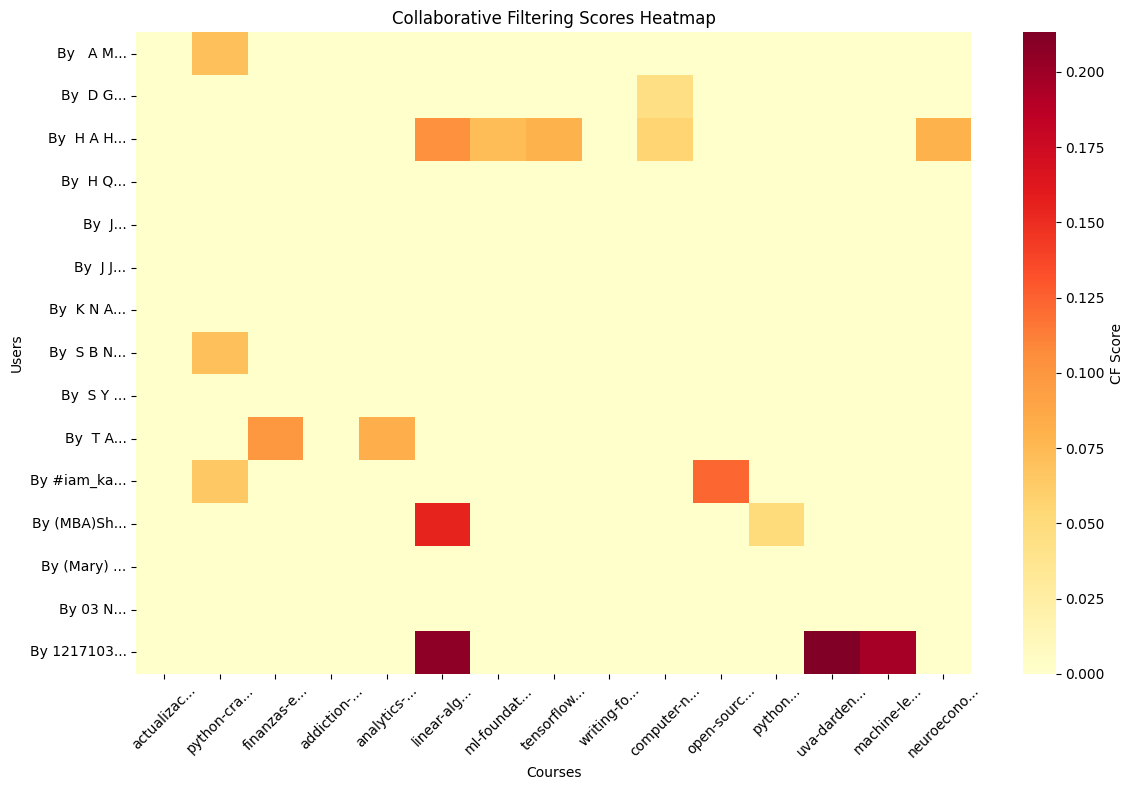

5. Recommendation Breakdown


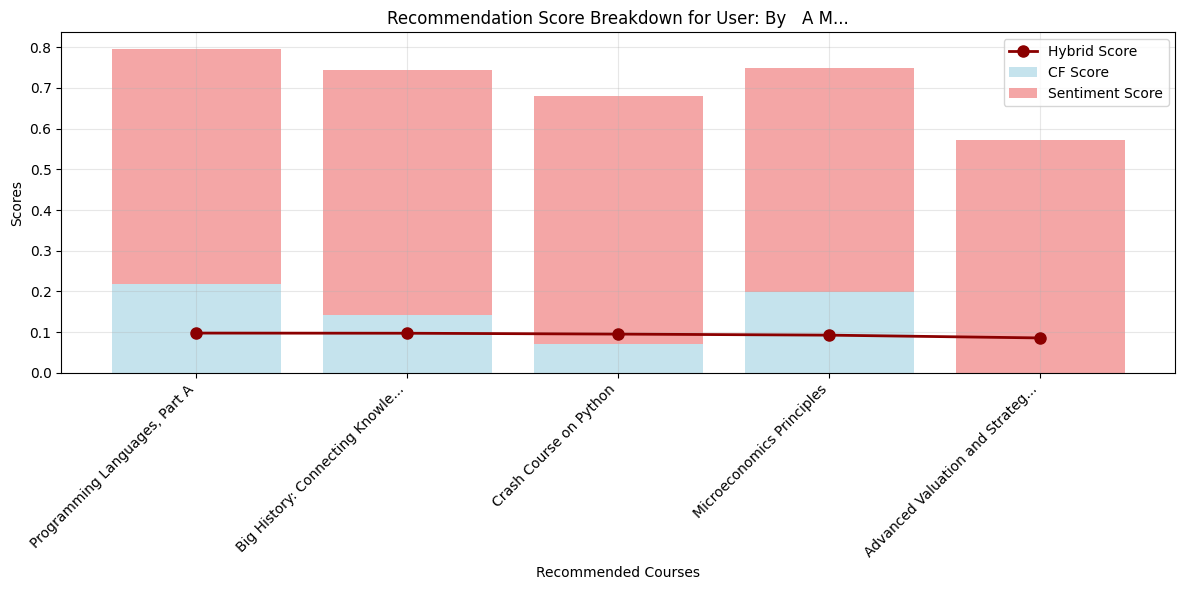

6. Interactive Dashboard



 All visualizations completed!
 Evaluation metrics and visualizations are ready for analysis


In [14]:
# Cell 7: Visualization Dashboard
!pip install plotly
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

class RecommenderVisualizer:
    def __init__(self, evaluation_results, cf_scores, sentiment_scores, courses_df):
        self.evaluation_results = evaluation_results
        self.cf_scores = cf_scores
        self.sentiment_scores = sentiment_scores
        self.courses_df = courses_df
        
    def plot_metrics_comparison(self):
        """Plot comparison of evaluation metrics across different K values"""
        k_values = list(self.evaluation_results.keys())
        metrics = ['precision@k', 'recall@k', 'ndcg@k', 'ctr', 'conversion_rate']
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics):
            values = [self.evaluation_results[k][metric] for k in k_values]
            axes[i].bar(k_values, values, color='skyblue', alpha=0.7)
            axes[i].set_title(f'{metric.upper()} vs K')
            axes[i].set_xlabel('K')
            axes[i].set_ylabel(metric)
            axes[i].grid(True, alpha=0.3)
            
            # Add value labels on bars
            for j, v in enumerate(values):
                axes[i].text(k_values[j], v + 0.01, f'{v:.3f}', 
                           ha='center', va='bottom')
        
        # Remove empty subplot
        axes[-1].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Recommender System Evaluation Metrics', fontsize=16, y=1.02)
        plt.show()
    
    def plot_metric_trends(self):
        """Plot trend lines for metrics across K values"""
        k_values = list(self.evaluation_results.keys())
        
        metrics_data = {
            'Precision@K': [self.evaluation_results[k]['precision@k'] for k in k_values],
            'Recall@K': [self.evaluation_results[k]['recall@k'] for k in k_values],
            'NDCG@K': [self.evaluation_results[k]['ndcg@k'] for k in k_values],
            'CTR': [self.evaluation_results[k]['ctr'] for k in k_values],
            'Conversion Rate': [self.evaluation_results[k]['conversion_rate'] for k in k_values]
        }
        
        plt.figure(figsize=(12, 8))
        for metric_name, values in metrics_data.items():
            plt.plot(k_values, values, marker='o', linewidth=2, markersize=8, label=metric_name)
        
        plt.xlabel('K (Number of Recommendations)')
        plt.ylabel('Metric Value')
        plt.title('Recommender Metrics Trend Across Different K Values')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(k_values)
        plt.show()
    
    def plot_sentiment_distribution(self):
        """Plot distribution of sentiment scores across courses"""
        sentiment_values = list(self.sentiment_scores.values())
        
        plt.figure(figsize=(10, 6))
        plt.hist(sentiment_values, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
        plt.axvline(np.mean(sentiment_values), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(sentiment_values):.3f}')
        plt.xlabel('Sentiment Score')
        plt.ylabel('Number of Courses')
        plt.title('Distribution of Course Sentiment Scores')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Print sentiment statistics
        print("Sentiment Score Statistics:")
        print(f"Mean: {np.mean(sentiment_values):.3f}")
        print(f"Median: {np.median(sentiment_values):.3f}")
        print(f"Std Dev: {np.std(sentiment_values):.3f}")
        print(f"Min: {np.min(sentiment_values):.3f}")
        print(f"Max: {np.max(sentiment_values):.3f}")
    
    def plot_collaborative_filtering_heatmap(self, sample_size=20):
        """Plot heatmap of collaborative filtering scores"""
        # Sample users and courses for visualization
        sample_users = list(self.cf_scores.keys())[:sample_size]
        
        # Get all courses from sampled users
        all_courses = set()
        for user in sample_users:
            all_courses.update(self.cf_scores[user].keys())
        sample_courses = list(all_courses)[:sample_size]
        
        # Create score matrix
        score_matrix = np.zeros((len(sample_users), len(sample_courses)))
        
        for i, user in enumerate(sample_users):
            for j, course in enumerate(sample_courses):
                score_matrix[i, j] = self.cf_scores[user].get(course, 0)
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(score_matrix, 
                   xticklabels=[course[:10] + '...' for course in sample_courses],
                   yticklabels=[user[:10] + '...' for user in sample_users],
                   cmap='YlOrRd', 
                   cbar_kws={'label': 'CF Score'})
        plt.title('Collaborative Filtering Scores Heatmap')
        plt.xlabel('Courses')
        plt.ylabel('Users')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    def plot_recommendation_breakdown(self, user_id, recommendations):
        """Plot breakdown of recommendation scores for a specific user"""
        if user_id not in self.cf_scores:
            print(f"User {user_id} not found in CF data")
            return
        
        cf_scores = []
        sentiment_scores = []
        hybrid_scores = []
        course_names = []
        
        for course_id, course_name, hybrid_score in recommendations:
            cf_score = self.cf_scores[user_id].get(course_id, 0)
            sentiment_score = self.sentiment_scores.get(course_id, 0.5)
            
            cf_scores.append(cf_score)
            sentiment_scores.append(sentiment_score)
            hybrid_scores.append(hybrid_score)
            course_names.append(course_name[:30] + '...' if len(course_name) > 30 else course_name)
        
        # Create stacked bar chart
        x_pos = np.arange(len(course_names))
        width = 0.8
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        bars1 = ax.bar(x_pos, cf_scores, width, label='CF Score', 
                      color='lightblue', alpha=0.7)
        bars2 = ax.bar(x_pos, sentiment_scores, width, bottom=cf_scores, 
                      label='Sentiment Score', color='lightcoral', alpha=0.7)
        
        # Add hybrid score line
        ax.plot(x_pos, hybrid_scores, 'o-', color='darkred', linewidth=2, 
               markersize=8, label='Hybrid Score')
        
        ax.set_xlabel('Recommended Courses')
        ax.set_ylabel('Scores')
        ax.set_title(f'Recommendation Score Breakdown for User: {user_id[:15]}...')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(course_names, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def create_interactive_dashboard(self, sample_users=5):
        """Create an interactive dashboard with multiple visualizations"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Metrics vs K', 'Sentiment Distribution', 
                          'Score Components', 'Performance Summary'),
            specs=[[{"type": "scatter"}, {"type": "histogram"}],
                   [{"type": "bar"}, {"type": "table"}]]
        )
        
        # 1. Metrics vs K
        k_values = list(self.evaluation_results.keys())
        for metric in ['precision@k', 'recall@k', 'ndcg@k']:
            values = [self.evaluation_results[k][metric] for k in k_values]
            fig.add_trace(
                go.Scatter(x=k_values, y=values, name=metric.upper()),
                row=1, col=1
            )
        
        # 2. Sentiment distribution
        sentiment_values = list(self.sentiment_scores.values())
        fig.add_trace(
            go.Histogram(x=sentiment_values, name='Sentiment Scores'),
            row=1, col=2
        )
        
        # 3. Score components for sample user
        if sample_users > 0:
            sample_user = list(self.cf_scores.keys())[0]
            recommendations = improved_hybrid_rec.get_hybrid_recommendations(
                sample_user, weights=optimized_weights, n_recommendations=5
            )
            
            course_names = []
            cf_scores = []
            sentiment_scores = []
            
            for course_id, course_name, _ in recommendations:
                course_names.append(course_name[:20] + '...')
                cf_scores.append(self.cf_scores[sample_user].get(course_id, 0))
                sentiment_scores.append(self.sentiment_scores.get(course_id, 0.5))
            
            fig.add_trace(
                go.Bar(name='CF Score', x=course_names, y=cf_scores),
                row=2, col=1
            )
            fig.add_trace(
                go.Bar(name='Sentiment Score', x=course_names, y=sentiment_scores),
                row=2, col=1
            )
        
        # 4. Performance summary table
        metrics_data = []
        for k in k_values:
            metrics_data.append([
                f"K={k}",
                f"{self.evaluation_results[k]['precision@k']:.3f}",
                f"{self.evaluation_results[k]['recall@k']:.3f}",
                f"{self.evaluation_results[k]['ndcg@k']:.3f}",
                f"{self.evaluation_results[k]['conversion_rate']:.3f}"
            ])
        
        fig.add_trace(
            go.Table(
                header=dict(values=['K', 'Precision', 'Recall', 'NDCG', 'Conversion']),
                cells=dict(values=[[row[i] for row in metrics_data] for i in range(5)])
            ),
            row=2, col=2
        )
        
        fig.update_layout(height=800, title_text="Recommender System Dashboard")
        fig.show()

# Initialize visualizer
print("Initializing Recommender Visualizer...")
visualizer = RecommenderVisualizer(evaluation_results, cf_scores, sentiment_scores, courses_df)

# Create all visualizations
print("\n📊 Creating Visualizations...")

# 1. Metrics comparison
print("1. Metrics Comparison Chart")
visualizer.plot_metrics_comparison()

# 2. Metric trends
print("2. Metric Trends Chart")
visualizer.plot_metric_trends()

# 3. Sentiment distribution
print("3. Sentiment Distribution")
visualizer.plot_sentiment_distribution()

# 4. CF heatmap
print("4. Collaborative Filtering Heatmap")
visualizer.plot_collaborative_filtering_heatmap(sample_size=15)

# 5. Recommendation breakdown for sample user
print("5. Recommendation Breakdown")
sample_user = list(cf_scores.keys())[0]
sample_recommendations = improved_hybrid_rec.get_hybrid_recommendations(
    sample_user, weights=optimized_weights, n_recommendations=5
)
visualizer.plot_recommendation_breakdown(sample_user, sample_recommendations)

# 6. Interactive dashboard
print("6. Interactive Dashboard")
visualizer.create_interactive_dashboard()

print(f"\n All visualizations completed!")
print(f" Evaluation metrics and visualizations are ready for analysis")